In [1]:
from data_init import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_size = 640
segment_to_skip = 100

train, val, test, norm_info = get_data()
X_train, X_train_normalized, y_train, y_train_normalized = train
X_val, X_val_normalized, y_val, y_val_normalized = val
X_test, X_test_normalized, y_test, y_test_normalized = test
X_normalization_info, y_normalization_info = norm_info

In [2]:
X_test_old, X_test_old_normalized, y_test_old, y_test_old_normalized = get_old_predicts(X_normalization_info, y_normalization_info)

In [3]:
# find sample where X_test[:, 0, :] != X_test_old[:, 0, :]
j = 0
index = 0
for i in range(X_test.shape[0]):
    if not torch.all(X_test[i, 0, :] == X_test_old[i + j, 0, :]):
        index = i
        j+=1

# delete index from X_test_old
X_test_old = torch.cat([X_test_old[:index], X_test_old[index + 1:]], dim=0)
X_test_old_normalized = torch.cat([X_test_old_normalized[:index], X_test_old_normalized[index + 1:]], dim=0)
y_test_old = torch.cat([y_test_old[:index], y_test_old[index + 1:]], dim=0)
y_test_old_normalized = torch.cat([y_test_old_normalized[:index], y_test_old_normalized[index + 1:]], dim=0)


In [4]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 5
output_channels = 3
batch_size = 32

class SimpleFeedForward(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleFeedForward, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_channels * sequence_length, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.fc2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 2056)
        self.batchnorm4 = nn.BatchNorm1d(2056)
        self.fc5 = nn.Linear(2056, output_channels * sequence_length)
        
        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)
        
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.relu(self.batchnorm3(self.fc3(x)))
        x = self.relu(self.batchnorm4(self.fc4(x)))
        x = self.fc5(x)
        
        x = x.reshape(batch_size, self.output_channels, sequence_length)
        
        return x

# Create an instance of the SimpleConvNet
model = SimpleFeedForward(input_channels, output_channels)


In [5]:
# load the best model
model_baseline = SimpleFeedForward(input_channels, output_channels)
model_baseline.load_state_dict(torch.load('best_model_baseline.pth', map_location=device))
model_baseline.eval()

model_mass_conservation = SimpleFeedForward(input_channels, output_channels)
model_mass_conservation.load_state_dict(torch.load('best_model_mass_conservation.pth', map_location=device))
model_mass_conservation.eval()

model_momentum_conservation = SimpleFeedForward(input_channels, output_channels)
model_momentum_conservation.load_state_dict(torch.load('best_model_momentum_conservation.pth', map_location=device))
model_momentum_conservation.eval()

model_mass_momentum_conservation = SimpleFeedForward(input_channels, output_channels)
model_mass_momentum_conservation.load_state_dict(torch.load('best_model_mass_momentum_conservation.pth', map_location=device))
model_mass_momentum_conservation.eval()

SimpleFeedForward(
  (relu): ReLU()
  (fc1): Linear(in_features=2700, out_features=2056, bias=True)
  (batchnorm1): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2056, out_features=1024, bias=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=2056, bias=True)
  (batchnorm4): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=2056, out_features=1620, bias=True)
)

In [6]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt
import numpy as np

y_pred_baseline_norm, y_pred_mass_norm, y_pred_momentum_norm, y_pred_mass_momentum_norm = \
    model_baseline(X_test_normalized[:, :, :]), \
    model_mass_conservation(X_test_normalized[:, :, :]), \
    model_momentum_conservation(X_test_normalized[:, :, :]), \
    model_mass_momentum_conservation(X_test_normalized[:, :, :])

# denormalize
y_pred_baseline, y_pred_mass, y_pred_momentum, y_pred_mass_momentum = \
    denormalize(y_pred_baseline_norm, y_normalization_info).detach().numpy(), \
    denormalize(y_pred_mass_norm, y_normalization_info).detach().numpy(), \
    denormalize(y_pred_momentum_norm, y_normalization_info).detach().numpy(), \
    denormalize(y_pred_mass_momentum_norm, y_normalization_info).detach().numpy()

In [7]:
# smooth predictions
y_pred_baseline_smooth, y_pred_mass_smooth, y_pred_momentum_smooth, y_pred_mass_momentum_smooth = y_pred_baseline.copy(), y_pred_mass.copy(), y_pred_momentum.copy(), y_pred_mass_momentum.copy()

y_preds = [y_pred_baseline_smooth, y_pred_mass_smooth, y_pred_momentum_smooth, y_pred_mass_momentum_smooth]

for y_pred_smooth in y_preds:
    for i in range(y_pred_smooth.shape[0]):
        for j in range(y_pred_smooth.shape[1]):
            y_pred_smooth[i, j, :] = pd.Series(y_pred_smooth[i, j, :]).rolling(window=8, min_periods=1, win_type='hamming').mean()

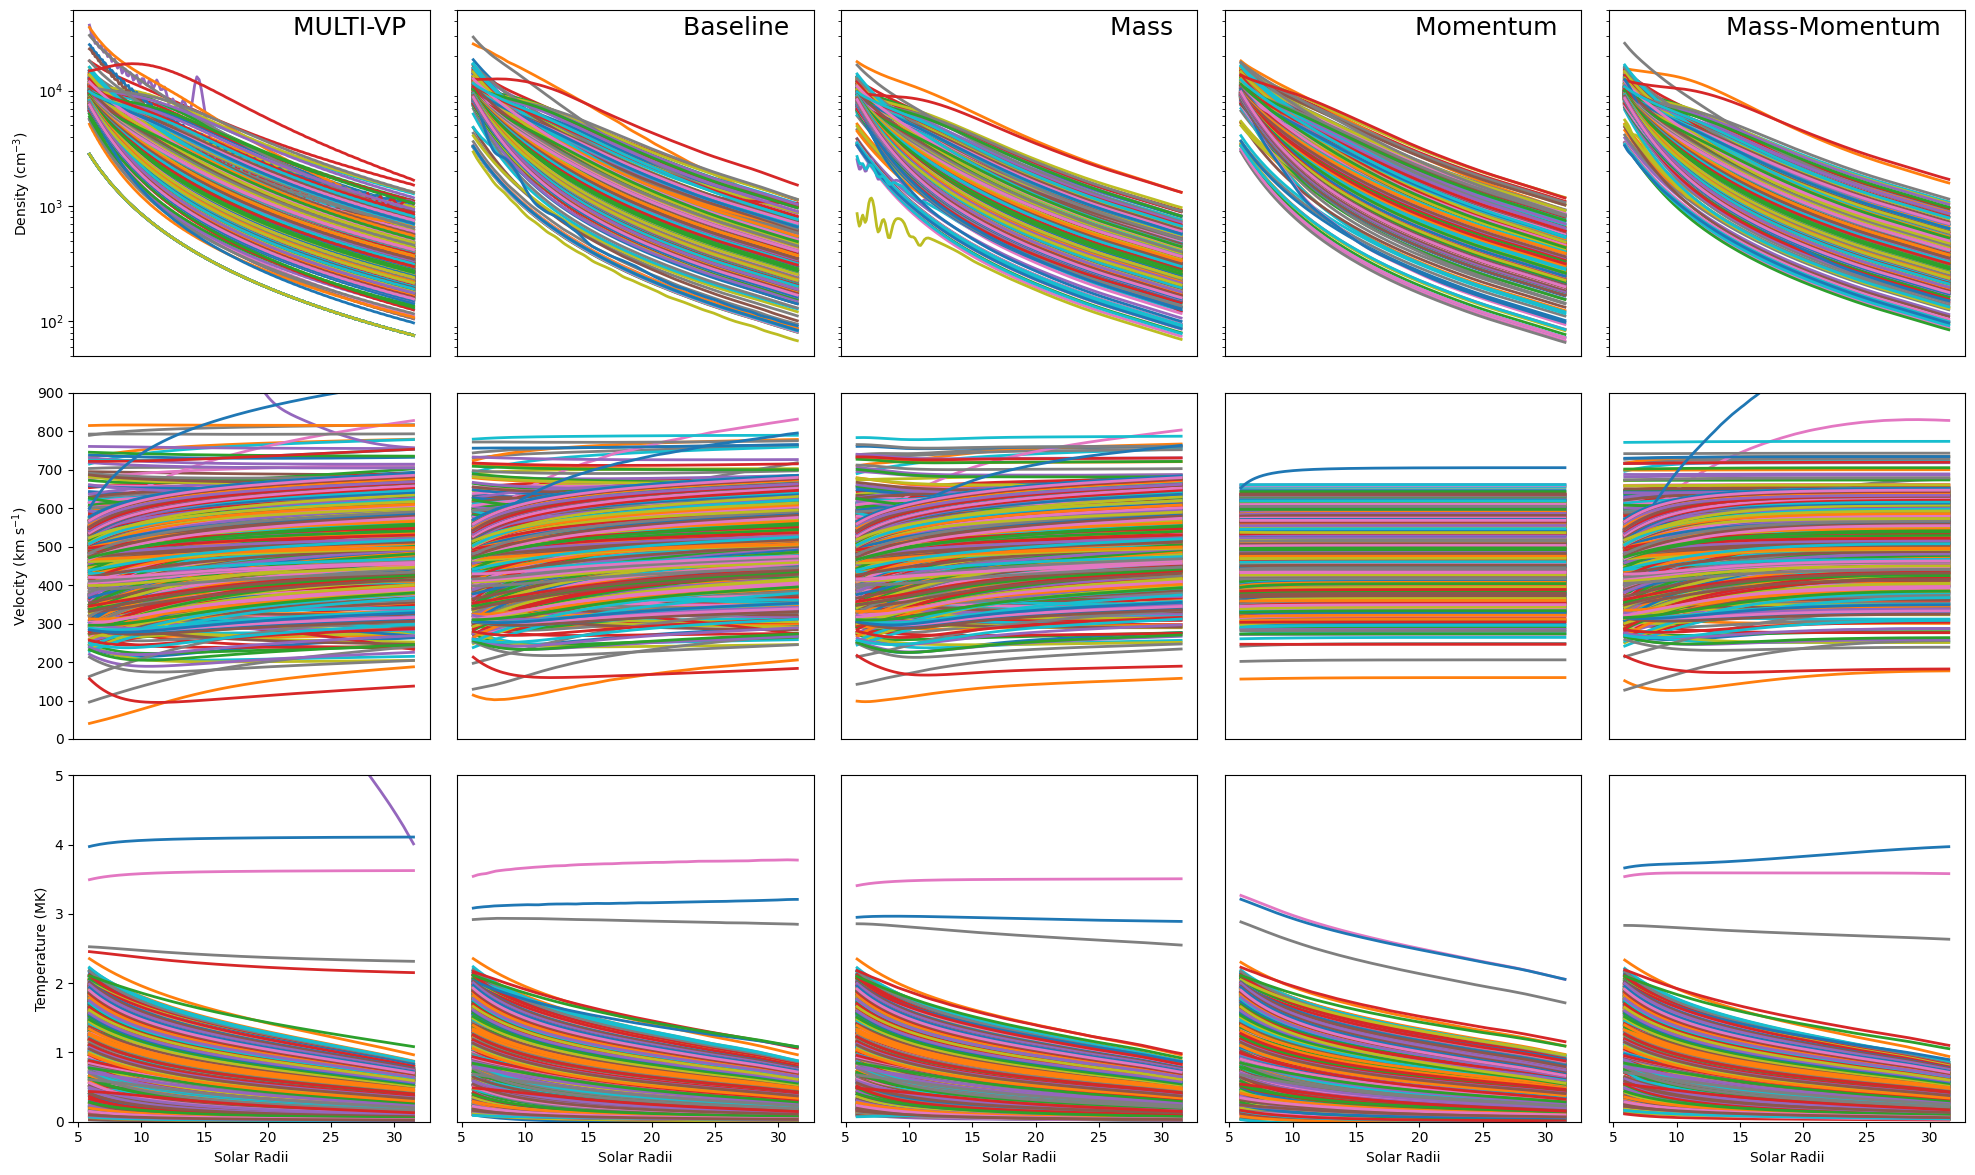

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
plt.rcParams.update({'font.size': 15, 'axes.titlesize' : 18, 'axes.labelsize' : 18, 'lines.linewidth' : 2, 'lines.markersize' : 10, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10})

output_names = ['n', 'v', 'T']
lims = [[25, 50000], [0, 900], [0, 5]]

for i in range(3):
    axs[i, 0].plot(X_test[:, 1, 400:].T, y_test[:, i, 400:].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 0].set_ylim(lims[i])
    #axs[i, 1].plot(X_test[:, 1, 400:].T, y_test_old[:, i, 400:].T)
    #axs[i, 1].set_yscale('log') if i == 0 else None
    #axs[i, 1].set_ylim(lims[i])
    axs[i, 1].plot(X_test[:, 1, 400:].T, y_pred_baseline_smooth[:, i, 400:].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 1].get_yaxis().set_ticks([])
    axs[i, 1].set_ylim(lims[i])
    axs[i, 2].plot(X_test[:, 1, 400:].T, y_pred_mass_smooth[:, i, 400:].T)
    axs[i, 2].set_yscale('log') if i == 0 else None
    axs[i, 2].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 2].get_yaxis().set_ticks([])
    axs[i, 2].set_ylim(lims[i])
    axs[i, 3].plot(X_test[:, 1, 400:].T, y_pred_momentum_smooth[:, i, 400:].T)
    axs[i, 3].set_yscale('log') if i == 0 else None
    axs[i, 3].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 3].set_ylim(lims[i])
    axs[i, 3].get_yaxis().set_ticks([])
    axs[i, 4].plot(X_test[:, 1, 400:].T, y_pred_mass_momentum_smooth[:, i, 400:].T)
    axs[i, 4].set_yscale('log') if i == 0 else None
    axs[i, 4].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 4].set_ylim(lims[i])
    axs[i, 4].get_yaxis().set_ticks([])
    

    
axs[0, 0].set_title(f'MULTI-VP   ', y=1.0, pad=-18, loc='right')
#axs[0, 1].set_title(f'Old Baseline')
axs[0, 1].set_title(f'Baseline   ', y=1.0, pad=-18, loc='right')
axs[0, 2].set_title(f'Mass   ', y=1.0, pad=-18, loc='right')
axs[0, 3].set_title(f'Momentum   ', y=1.0, pad=-18, loc='right')
axs[0, 4].set_title(f'Mass-Momentum   ', y=1.0, pad=-18, loc='right')

axs[0, 0].set_ylabel('Density (cm$^{-3}$)')	
axs[1, 0].set_ylabel('Velocity (km s$^{-1}$)')
axs[2, 0].set_ylabel('Temperature (MK)')

axs[2, 0].set_xlabel('Solar Radii')
axs[2, 1].set_xlabel('Solar Radii')
axs[2, 2].set_xlabel('Solar Radii')
axs[2, 3].set_xlabel('Solar Radii')
axs[2, 4].set_xlabel('Solar Radii')
#axs[2, 5].set_xlabel('Solar Radii')

plt.tight_layout()
plt.show()


In [17]:
fig.savefig("results_pinn.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(10, 20))

models = ['MULTI-VP', 'Old Baseline', 'New Baseline', 'Mass', 'Momentum', 'Mass+Momentum']
preds = [y_test, y_test_old, y_pred_baseline_smooth, y_pred_mass_smooth, y_pred_momentum_smooth, y_test]

lims = [[50, 50000], [0, 900], [0, 3.5]]

for i, pred in enumerate(preds):
    axs[i, 0].plot(X_test[:, 1, 400:].T, pred[:, 0, 400:].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[0])
    axs[i, 1].plot(X_test[:, 1, 400:].T, pred[:, 1, 400:].T)
    axs[i, 1].set_ylim(lims[1])
    axs[i, 2].plot(X_test[:, 1, 400:].T, pred[:, 2, 400:].T)
    axs[i, 2].set_ylim(lims[2])

# set titles
axs[0, 0].set_title('Density (n)')
axs[0, 1].set_title('Velocity (v)')
axs[0, 2].set_title('Temperature (T)')

# set y labels
axs[0, 0].set_ylabel('MULTI-VP')
axs[1, 0].set_ylabel('Old Baseline')
axs[2, 0].set_ylabel('New Baseline')
axs[3, 0].set_ylabel('Mass')
axs[4, 0].set_ylabel('Momentum')

plt.show()


In [8]:
# calculate the coefficient of variation
def calculate_cv(y_pred):
    return torch.mean(torch.std(y_pred, axis=0) / torch.mean(y_pred, axis=0))

y_test_cv = calculate_cv(y_test[:, :, 400:])
y_test_old_cv = calculate_cv(y_test_old[:, :, 400:])
y_pred_baseline_cv = calculate_cv(torch.Tensor(y_pred_baseline[:, :, 400:]))
y_pred_mass_cv = calculate_cv(torch.Tensor(y_pred_mass[:, :, 400:]))
y_pred_momentum_cv = calculate_cv(torch.Tensor(y_pred_momentum[:, :, 400:]))
y_pred_mass_momentum_cv = calculate_cv(torch.Tensor(y_pred_mass_momentum[:, :, 400:]))

y_test_cv, y_test_old_cv, y_pred_baseline_cv, y_pred_mass_cv, y_pred_momentum_cv, y_pred_mass_momentum_cv

(tensor(0.3915987475),
 tensor(0.1302417943),
 tensor(0.3355045493),
 tensor(0.3161319574),
 tensor(0.3052543850),
 tensor(0.3195825303))

In [9]:
# calculate mse

def calculate_mse(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

y_test_mse = calculate_mse(y_test_normalized[:, :, 400:], y_test_normalized[:, :, 400:])
y_test_old_mse = calculate_mse(y_test_old_normalized[:, :, 400:], y_test_normalized[:, :, 400:])
y_pred_baseline_mse = calculate_mse(torch.Tensor(y_pred_baseline_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_mass_mse = calculate_mse(torch.Tensor(y_pred_mass_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_momentum_mse = calculate_mse(torch.Tensor(y_pred_momentum_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_mass_momentum_mse = calculate_mse(torch.Tensor(y_pred_mass_momentum_norm[:, :, 400:]), y_test_normalized[:, :, 400:])

y_test_mse, y_test_old_mse, y_pred_baseline_mse, y_pred_mass_mse, y_pred_momentum_mse, y_pred_mass_momentum_mse

(tensor(0.),
 tensor(0.2431410087),
 tensor(0.0360367252, grad_fn=<MeanBackward0>),
 tensor(0.0369175921, grad_fn=<MeanBackward0>),
 tensor(0.0585438716, grad_fn=<MeanBackward0>),
 tensor(0.0377181721, grad_fn=<MeanBackward0>))

In [17]:
# std of n*v/B should be 0 
y_test_nvt = y_test[:, 0, 400:] * y_test[:, 1, 400:] / X_test[:, 2, 400:]
y_test_old_nvt = y_test_old[:, 0, 400:] * y_test_old[:, 1, 400:] / X_test_old[:, 2, 400:]
y_pred_baseline_nvt = y_pred_baseline[:, 0, 400:] * y_pred_baseline[:, 1, 400:] / X_test[:, 2, 400:]
y_pred_mass_nvt = y_pred_mass[:, 0, 400:] * y_pred_mass[:, 1, 400:] / X_test[:, 2, 400:]
y_pred_momentum_nvt = y_pred_momentum[:, 0, 400:] * y_pred_momentum[:, 1, 400:] / X_test[:, 2, 400:]
y_pred_mass_momentum_nvt = y_pred_mass_momentum[:, 0, 400:] * y_pred_mass_momentum[:, 1, 400:] / X_test[:, 2, 400:]

y_test_nvt.shape, y_test_old_nvt.shape, y_pred_baseline_nvt.shape, y_pred_mass_nvt.shape, y_pred_momentum_nvt.shape

(torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]))

In [18]:
mass_loss_test = torch.std(y_test_nvt, dim=1).mean()
mass_loss_old = torch.std(torch.Tensor(y_test_old_nvt), dim=1).mean()
mass_loss_baseline = torch.std(torch.Tensor(y_pred_baseline_nvt), dim=1).mean()
mass_loss_mass = torch.std(torch.Tensor(y_pred_mass_nvt), dim=1).mean()
mass_loss_momentum = torch.std(torch.Tensor(y_pred_momentum_nvt), dim=1).mean()
mass_loss_mass_momentum = torch.std(torch.Tensor(y_pred_mass_momentum_nvt), dim=1).mean()

mass_loss_test, mass_loss_old, mass_loss_baseline, mass_loss_mass, mass_loss_momentum, mass_loss_mass_momentum

(tensor(1455406.0967634567),
 tensor(11690369.5895765498),
 tensor(2029109.1771991737),
 tensor(1520158.4176277572),
 tensor(11347156.1522370391),
 tensor(1767455.7847349886))

In [19]:
import torch

def lagrange_derivative(x, x0, x1, x2, y0, y1, y2):
    p0 = y0 * (2*x-x1-x2) / ((x0-x1)*(x0-x2))
    p1 = y1 * (2*x-x0-x2) / ((x1-x0)*(x1-x2))
    p2 = y2 * (2*x-x0-x1) / ((x2-x0)*(x2-x1))
    return p0 + p1 + p2

def cfd(x, y):
    """
    Adjusted function to compute the central first order derivative for uneven space sequences,
    with NaN handling without for loops.
    """
    d1 = torch.zeros_like(x)

    y0, y1, y2 = y[:, 0], y[:, 1], y[:, 2]
    x0, x1, x2 = x[:, 0], x[:, 1], x[:, 2]
    d1[:, 0] = lagrange_derivative(x0, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, :-2], y[:, 1:-1], y[:, 2:]
    x0, x1, x2 = x[:, :-2], x[:, 1:-1], x[:, 2:]
    d1[:, 1:-1] = lagrange_derivative(x1, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, -3], y[:, -2], y[:, -1]
    x0, x1, x2 = x[:, -3], x[:, -2], x[:, -1]
    d1[:, -1] = lagrange_derivative(x2, x0, x1, x2, y0, y1, y2)

    return d1

def csd(x, y):
    """
    Computes the central second order derivative for uneven space sequences
    without using for loops, including handling for NaN values.
    """
    d2 = torch.zeros_like(x)
    
    i = torch.arange(1, x.size(1) - 1)
    y0, y1, y2 = y[:, i-1], y[:, i], y[:, i+1]
    x0, x1, x2 = x[:, i-1], x[:, i], x[:, i+1]
    central_d2 = 2.0 * ((x1 - x0) * y2 - (x2 - x0) * y1 + (x2 - x1) * y0) / ((x1 - x0) * (x2 - x1) * (x2 - x0))
    d2[:, i] = central_d2
    
    d2[:, 0] = 2.0 * ((x[:, 1]-x[:, 0])*y[:, 2] - (x[:, 2]-x[:, 0])*y[:, 1] + (x[:, 2]-x[:, 1])*y[:, 0]) / \
              ((x[:, 1]-x[:, 0])*(x[:, 2]-x[:, 1])*(x[:, 2]-x[:, 0]))
    
    d2[:, -1] = 2.0 * ((x[:, -2]-x[:, -3])*y[:, -1] - (x[:, -1]-x[:, -3])*y[:, -2] + (x[:, -1]-x[:, -2])*y[:, -3]) / \
               ((x[:, -2]-x[:, -3])*(x[:, -1]-x[:, -2])*(x[:, -1]-x[:, -3]))

    return d2

In [20]:
DX_UN  =   6.96000e+10  # length unit factor (to cm)
VX_UN  =   1e+05 # speed unit factor (to cm/s)
TE_UN  =   1.00000e+06  # temperature unit factor (to K)
NE_UN  =   1.00000e+17  # density unit factor (to 1/cm^3)
DT_UN  =       5413.93  # time unit factor (to s)

NU_UN = (DX_UN**2)/DT_UN   # viscosity coeff init factor (to cm^2/s)

NU_VISC = .1 * NU_UN    # the actual viscosity coeff

In [21]:
class ConservationCriterion(nn.Module):
    def __init__(self, normalization_info_inputs, normalization_info_outputs):
        super(ConservationCriterion, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.smooth_l1 = nn.SmoothL1Loss()
        self.normalization_info_inputs = normalization_info_inputs
        self.normalization_info_outputs = normalization_info_outputs
        self.lambda_momentum = 0
        self.lambda_mass = 0
        self.G = 6.6743e-11
        self.nu_visc = NU_VISC
        
    def forward(self, inputs, preds):
        inputs_denormalized = denormalize(inputs, self.normalization_info_inputs)
        
        preds_denormalized = denormalize(preds, self.normalization_info_outputs)
        
        idx = 400 # why?
        
        R, L, a_a0, alpha = inputs_denormalized[:, 0, idx:] * DX_UN, inputs_denormalized[:, 1, idx:] * DX_UN, inputs_denormalized[:, 3, idx:] / DX_UN, inputs_denormalized[:, 4, idx:]
        n_pred, v_pred, T_pred = preds_denormalized[:, 0, idx:], preds_denormalized[:, 1, idx:] * VX_UN, preds_denormalized[:, 2, idx:] * TE_UN
                                            
        dnT_dL = cfd(L, n_pred * T_pred)
        dv2_dL = cfd(L, v_pred**2)
        dv_dL = cfd(L, v_pred)
        d2v_dL2 = csd(L, v_pred)
        gradp  = dnT_dL / n_pred

        gravf  = self.G * torch.cos(alpha) / R**2
        
        vgradva  = dv2_dL
        vgradvc  = -v_pred * dv_dL
        vgradv = vgradva + vgradvc 

        visca = d2v_dL2
        viscb = dv_dL * a_a0
        visc  = -self.nu_visc * (visca + viscb)
                
        momentum_loss = ((vgradv + gradp + visc + gravf)**2).nanmean().sqrt()

        return momentum_loss

In [22]:
criterion = ConservationCriterion(X_normalization_info, y_normalization_info)

momentum_loss_test = criterion(X_test_normalized, y_test_normalized)
momentum_loss_old = criterion(X_test_normalized, y_test_old_normalized)
momentum_loss_baseline = criterion(X_test_normalized, y_pred_baseline_norm)
momentum_loss_mass = criterion(X_test_normalized, y_pred_mass_norm)
momentum_loss_momentum = criterion(X_test_normalized, y_pred_momentum_norm)
momentum_loss_mass_momentum = criterion(X_test_normalized, y_pred_mass_momentum_norm)

momentum_loss_test, momentum_loss_old, momentum_loss_baseline, momentum_loss_mass, momentum_loss_momentum, momentum_loss_mass_momentum

(tensor(28417.3818068230),
 tensor(42727.3014563284),
 tensor(21064.2950026563, grad_fn=<SqrtBackward0>),
 tensor(19248.0264828347, grad_fn=<SqrtBackward0>),
 tensor(171.7453964933, grad_fn=<SqrtBackward0>),
 tensor(9451.3542875766, grad_fn=<SqrtBackward0>))

In [25]:
# Assuming your MSE, Mass PR, and Momentum PR values are stored in arrays:
mse_values = np.array([y_test_mse.detach(), y_pred_baseline_mse.detach(), y_pred_mass_mse.detach(), y_pred_momentum_mse.detach(), y_pred_mass_momentum_mse.detach()])
mass_pr_values = np.array([mass_loss_test, mass_loss_baseline, mass_loss_mass, mass_loss_momentum, mass_loss_mass_momentum])
momentum_pr_values = np.array([momentum_loss_test.detach(), momentum_loss_baseline.detach(), momentum_loss_mass.detach(), momentum_loss_momentum.detach(), momentum_loss_mass_momentum.detach()])

mse_values, mass_pr_values, momentum_pr_values

(array([0.        , 0.03603673, 0.03691759, 0.05854387, 0.03771817]),
 array([ 1455406.09676346,  2029109.17719917,  1520158.41762776,
        11347156.15223704,  1767455.78473499]),
 array([28417.38180682, 21064.29500266, 19248.02648283,   171.74539649,
         9451.35428758]))

In [27]:
# Normalize each metric to a 0-1 range
norm_mse = (mse_values - np.min(mse_values)) / (np.max(mse_values) - np.min(mse_values))
norm_mass_pr = (mass_pr_values - np.min(mass_pr_values)) / (np.max(mass_pr_values) - np.min(mass_pr_values))
norm_momentum_pr = (momentum_pr_values - np.min(momentum_pr_values)) / (np.max(momentum_pr_values) - np.min(momentum_pr_values))

norm_mse, norm_mass_pr, norm_momentum_pr

(array([0.        , 0.61555077, 0.63059704, 1.        , 0.64427191]),
 array([0.        , 0.05799814, 0.00654609, 1.        , 0.03154646]),
 array([1.        , 0.73967353, 0.67537091, 0.        , 0.32853248]))

In [28]:
var_mse = np.var(norm_mse)
var_mass_pr = np.var(norm_mass_pr)
var_momentum_pr = np.var(norm_momentum_pr)

print(var_mse, var_mass_pr, var_momentum_pr)

w_mse = 1 / var_mse
w_mass_pr = 1 / var_mass_pr
w_momentum_pr = 1 / var_momentum_pr

print(w_mse, w_mass_pr, w_momentum_pr)

hybrid_metric = w_mse * norm_mse + w_mass_pr * norm_mass_pr + w_momentum_pr * norm_momentum_pr
hybrid_metric

0.10414728795976494 0.15282377083753484 0.12114670502935174
9.601786273938583 6.543484658961126 8.254454793118125


array([ 8.25445479, 12.39549857, 11.67251088, 16.14527093,  9.10444145])

In [29]:
min(hybrid_metric)

8.254454793118125